函式庫導入完成。

字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。
成功使用 'utf-8-sig' 編碼讀取檔案: 2023資料剖析後內容1~8月芝山到天母0609整理二版.csv

原始資料共有 5016 筆。

--- 步驟 2：開始進行資料清理 ---
移除了 1 筆時間極端或格式錯誤的資料。
資料清理完成，剩餘有效資料 0 筆。

--- 步驟 3：開始進行探索性資料分析 (EDA) ---
正在繪製盒鬚圖...


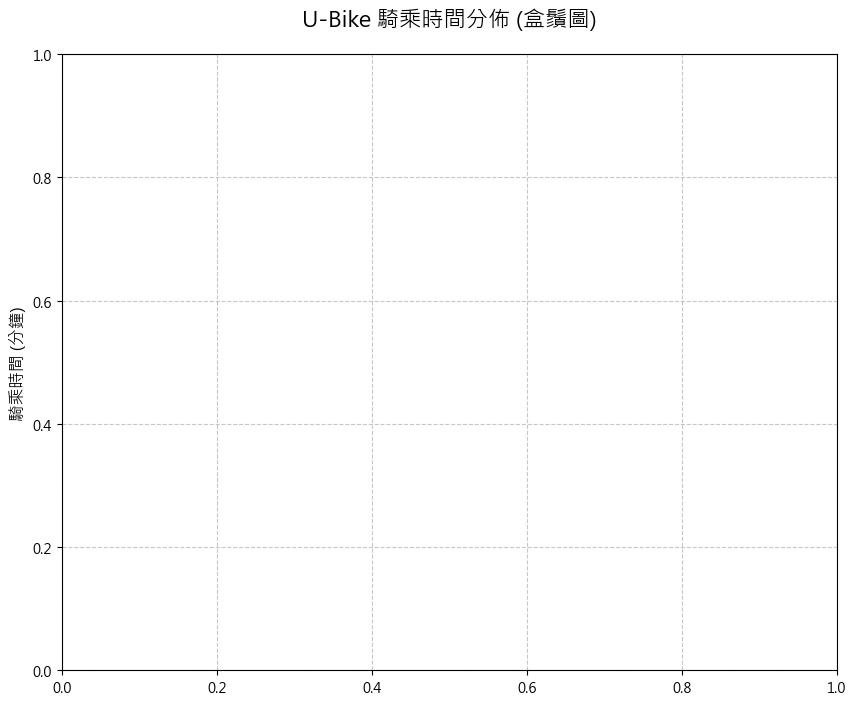

正在繪製常態分配圖...


IndexError: list index out of range

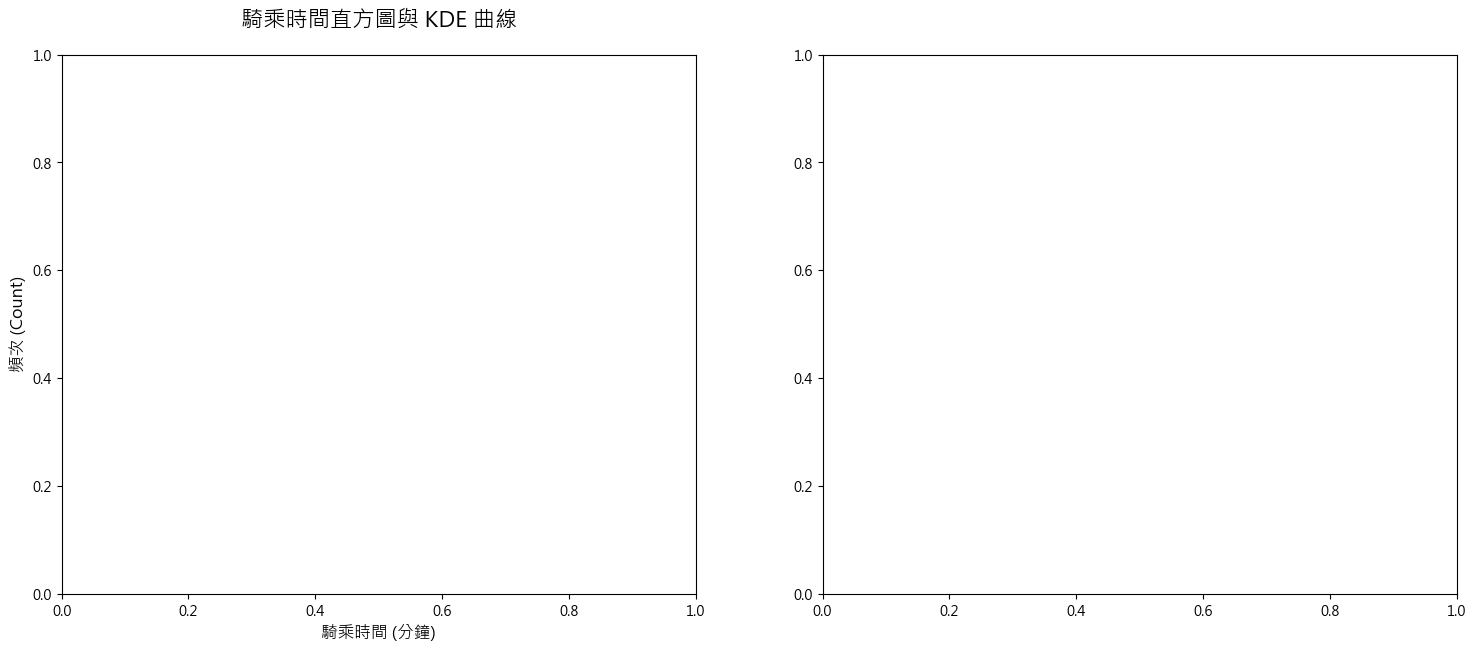

In [1]:
# =============================================================================
# 專案：U-Bike 騎乘時間預測模型 (Windows 11 中文顯示修正版)
# 描述：本腳本涵蓋從資料清理、探索性分析、特徵工程到模型訓練與評估的完整流程。
# 模型：LightGBM Regressor
# =============================================================================

# 步驟 0：導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import warnings

# 忽略一些 pandas 未來的警告，讓輸出更乾淨
warnings.filterwarnings('ignore', category=FutureWarning)

print("函式庫導入完成。\n")

# =============================================================================
# 步驟 1：資料載入與視覺化設定
# =============================================================================
# --- 設定 Matplotlib 顯示中文字體 (針對 Windows 11) ---
try:
    # 明確指定使用 Windows 11 繁體中文版預設的 '微軟正黑體'
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    # 解決負號 '-' 顯示為方塊的問題
    plt.rcParams['axes.unicode_minus'] = False 
    print("字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。")
except Exception as e:
    print(f"警告：設定中文字體時發生錯誤: {e}")
    print("圖表中的中文可能無法正常顯示。")


# --- 載入資料 ---
file_path = u'2023資料剖析後內容1~8月芝山到天母0609整理二版.csv' 
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
    print(f"成功使用 'utf-8-sig' 編碼讀取檔案: {file_path}")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='big5')
    print(f"成功使用 'big5' 編碼讀取檔案: {file_path}")
except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'。請確認檔案名稱和路徑是否正確。")
    exit()

print(f"\n原始資料共有 {len(df)} 筆。")


# =============================================================================
# 步驟 2：資料清理與預處理 (Data Cleaning & Preprocessing)
# =============================================================================
print("\n--- 步驟 2：開始進行資料清理 ---")

# 移除檔案結尾可能存在的文字說明行 (判斷依據：Date 欄位為空)
df.dropna(subset=['Date'], inplace=True)

def parse_time_to_seconds(time_str):
    try:
        return pd.to_timedelta(time_str).total_seconds()
    except (ValueError, TypeError):
        return None

df['TotalSeconds'] = df['Time2'].apply(parse_time_to_seconds)
df.dropna(subset=['TotalSeconds'], inplace=True)
original_rows = len(df)
df = df[(df['TotalSeconds'] >= 180) & (df['TotalSeconds'] <= 3600)] # 限制在 3 到 60 分鐘
print(f"移除了 {original_rows - len(df)} 筆時間極端或格式錯誤的資料。")
df['TotalSeconds'] = df['TotalSeconds'].astype(int)
df['TotalMinutes'] = df['TotalSeconds'] / 60

print(f"資料清理完成，剩餘有效資料 {len(df)} 筆。")


# =============================================================================
# 步驟 3：探索性資料分析 (Exploratory Data Analysis - EDA)
# =============================================================================
print("\n--- 步驟 3：開始進行探索性資料分析 (EDA) ---")

# 3.1 繪製盒鬚圖 (Box Plot)
print("正在繪製盒鬚圖...")
plt.figure(figsize=(10, 8))
sns.boxplot(y=df['TotalMinutes'], palette="viridis")
plt.title('U-Bike 騎乘時間分佈 (盒鬚圖)', fontsize=16, pad=20)
plt.ylabel('騎乘時間 (分鐘)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3.2 繪製常態分配圖 (Normality Plot)
print("正在繪製常態分配圖...")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# 左圖：直方圖與 KDE 曲線
sns.histplot(df['TotalMinutes'], kde=True, ax=axes[0], bins=40, color='skyblue')
axes[0].set_title('騎乘時間直方圖與 KDE 曲線', fontsize=16, pad=20)
axes[0].set_xlabel('騎乘時間 (分鐘)', fontsize=12)
axes[0].set_ylabel('頻次 (Count)', fontsize=12)
# 右圖：Q-Q 圖 (Quantile-Quantile Plot)
stats.probplot(df['TotalMinutes'], dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('b'); axes[1].get_lines()[0].set_markeredgecolor('b')
axes[1].get_lines()[0].set_markersize(4.0); axes[1].get_lines()[1].set_color('r')
axes[1].set_title('常態機率圖 (Q-Q Plot)', fontsize=16, pad=20)
axes[1].set_xlabel('理論分位數', fontsize=12)
axes[1].set_ylabel('樣本分位數', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


# =============================================================================
# 步驟 4：特徵工程 (Feature Engineering)
# =============================================================================
print("\n--- 步驟 4：開始進行特徵工程 ---")

# 4.1 處理日期與時間特徵
df['Date'] = df['Date'].astype(int).astype(str)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time1'], format='%Y%m%d %H:%M:%S')

# 4.2 建立時間相關特徵
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsRushHour'] = df['Hour'].apply(lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0)

# 4.3 處理地點類別特徵
def normalize_exit(stp_name):
    return 'Exit_1' if '1號' in str(stp_name) else 'Exit_2'
df['StartExit'] = df['Stp1'].apply(normalize_exit)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int64)
encoded_features = ohe.fit_transform(df[['StartExit']])
new_feature_names = ohe.get_feature_names_out(['StartExit'])
encoded_df = pd.DataFrame(encoded_features, columns=new_feature_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)

# 4.4 準備最終建模用的 DataFrame
columns_to_drop = ['Date', 'Week', 'Time1', 'AM/PM', 'Stp1', 'Stp2', 'Time2', 
                   'TotalMinutes', 'Datetime', 'StartExit']
df_model = df.drop(columns=columns_to_drop, errors='ignore')

print("特徵工程完成。")
print("最終用於建模的欄位：", df_model.columns.tolist())


# =============================================================================
# 步驟 5：模型訓練 (Model Training)
# =============================================================================
print("\n--- 步驟 5：開始訓練 LightGBM 模型 ---")

# 5.1 定義特徵 (X) 與目標 (y)
target = 'TotalSeconds'
features = [col for col in df_model.columns if col != target]
X = df_model[features]
y = df_model[target]

# 5.2 分割訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"訓練集大小: {X_train.shape[0]} 筆, 測試集大小: {X_test.shape[0]} 筆。")

# 5.3 初始化並訓練 LightGBM 模型
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

print("模型訓練完成！")


# =============================================================================
# 步驟 6：模型評估與視覺化 (Model Evaluation & Visualization)
# =============================================================================
print("\n--- 步驟 6：模型評估與結果分析 ---")

# 6.1 在測試集上進行預測並計算指標
y_pred = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"平均絕對誤差 (MAE): {mae:.2f} 秒 (約 {mae/60:.2f} 分鐘)")
print(f"決定係數 (R-squared, R²): {r2:.2f}")

# 6.2 繪製「預測值 vs. 實際值」散點圖
print("\n正在繪製「預測值 vs. 實際值」圖...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='預測點')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='完美預測線')
plt.title('模型預測時間 vs. 實際騎乘時間', fontsize=16, pad=20)
plt.xlabel('實際時間 (秒)', fontsize=12)
plt.ylabel('預測時間 (秒)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 6.3 繪製特徵重要性圖
print("\n正在繪製特徵重要性圖...")
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette="mako")
plt.title('模型特徵重要性分析', fontsize=16, pad=20)
plt.xlabel('重要性數值 (Importance Value)', fontsize=12)
plt.ylabel('特徵 (Feature)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n--- 專案執行完畢 ---")